In [2]:
#import modules
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
#define dataset path
dataset_path = "/content/dataset/gaussian_filtered_images/gaussian_filtered_images"

In [9]:
#check images per folder
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        print(folder, ":", len(os.listdir(folder_path)))

Moderate : 999
No_DR : 1805
.ipynb_checkpoints : 0
Mild : 370
Proliferate_DR : 261
Severe : 193


In [11]:
#create image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [12]:
#create training generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

Found 2904 images belonging to 6 classes.


In [13]:
#create validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 724 images belonging to 6 classes.


In [14]:
#check number of classes
print("Class indices:", train_generator.class_indices)
print("Number of classes:", train_generator.num_classes)

Class indices: {'.ipynb_checkpoints': 0, 'Mild': 1, 'Moderate': 2, 'No_DR': 3, 'Proliferate_DR': 4, 'Severe': 5}
Number of classes: 6


In [15]:
#build model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)

num_classes = train_generator.num_classes

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
#compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
#train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4407 - loss: 4.6460 - val_accuracy: 0.6188 - val_loss: 1.1626
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5776 - loss: 1.3190 - val_accuracy: 0.5691 - val_loss: 1.9121
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5432 - loss: 1.6249 - val_accuracy: 0.5110 - val_loss: 1.1685
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5864 - loss: 1.4011 - val_accuracy: 0.6326 - val_loss: 1.0133
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6065 - loss: 1.2304 - val_accuracy: 0.5249 - val_loss: 1.5010


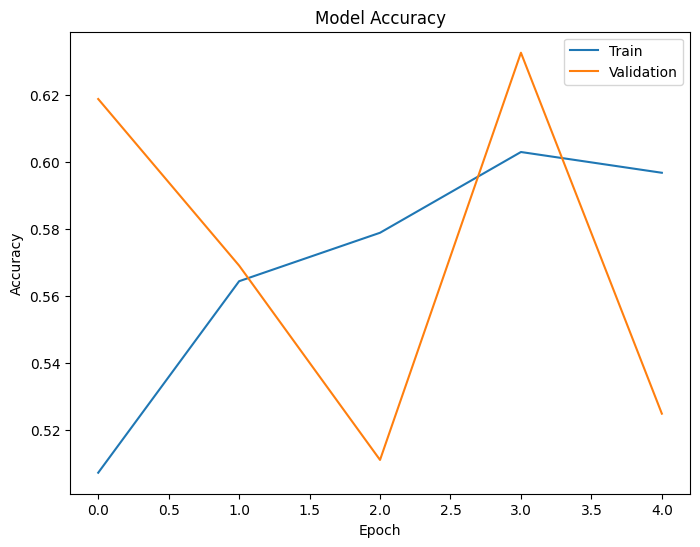

In [22]:
#plot accuracy graph
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.savefig("accuracy_graph.png", bbox_inches='tight')  # SAVE FIRST
plt.show()  # SHOW AFTER SAVING


46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step


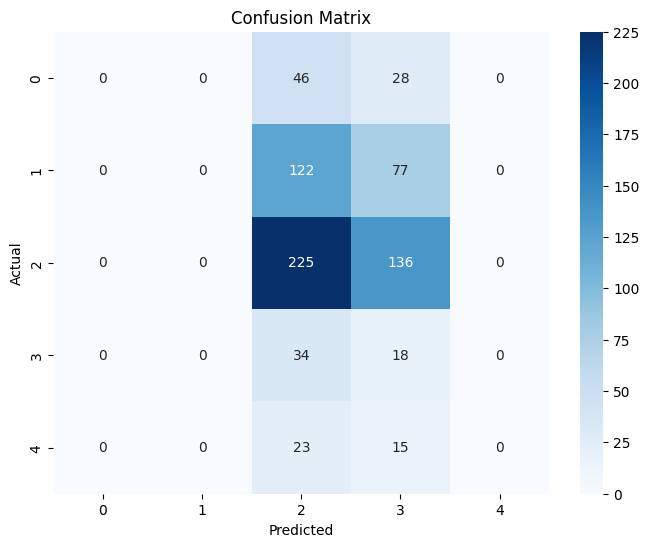

In [23]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_generator.reset()
pred = model.predict(val_generator)
pred_classes = np.argmax(pred, axis=1)
true_classes = val_generator.classes

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig("confusion_matrix.png", bbox_inches='tight')  # SAVE FIRST
plt.show()

In [25]:
#load sample image
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img_path = "/content/dataset/gaussian_filtered_images/gaussian_filtered_images/Mild/00cb6555d108.png"  # change image name

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [26]:
#predict for loaded image
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction) * 100

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print("Predicted:", predicted_label)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: No_DR
Confidence: 45.643436


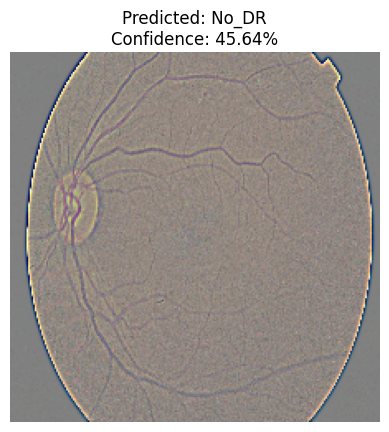

In [27]:
#show image with prediction
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
plt.axis("off")

plt.savefig("sample_prediction.png", dpi=300, bbox_inches='tight')
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


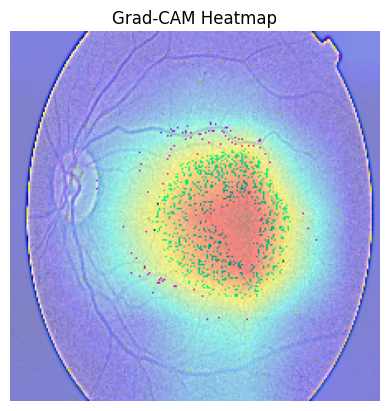

In [28]:
#grand cam implementation
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get last convolution layer
last_conv_layer = model.get_layer("conv5_block3_out")  # For ResNet50

grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer("conv5_block3_out").output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    class_idx = tf.argmax(predictions[0])
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Load original image
img_original = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img_original

cv2.imwrite("gradcam_result.png", superimposed_img)

plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grad-CAM Heatmap")
plt.show()